In [1]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import json
import pandas as pd
from cpymad.madx import Madx
#from matplotlib import pyplot as plt
import NAFFlib
from math import modf
#from scipy.constants import physical_constants
from matplotlib import pyplot as plt
from scipy.stats import linregress


In [52]:
#input
i_mo = -350
p0c = 7000e9
normal_emitt_x = 3e-6 #m*rad
normal_emitt_y = 3e-6
#proton_mass = physical_constants['proton mass energy equivalent in MeV'][0]/1000 

#ctx_gpu = xo.ContextCupy()
ctx_cpu = xo.ContextCpu()

if False:
    mad = Madx()
    mad.option(echo=False)
    mad.call('andrea.madx')
    mad.use(sequence="lhcb1")
    line = xt.Line.from_madx_sequence(mad.sequence['lhcb1'],
                                  deferred_expressions=True
                                  )
    with open('line.json', 'w') as fid:
        json.dump(line.to_dict(), fid, cls=xo.JEncoder)

else:
    with open('line.json', 'r') as fid:
        loaded_dct = json.load(fid)
    line = xt.Line.from_dict(loaded_dct)

    
particle_0 = xp.Particles(_context=ctx_cpu, p0c=p0c)

line.vars['i_mo'] = i_mo
line.vars['cmrs.b1_sq']=0.5*line.vars['cmrs.b1_sq']

#Testing two different tracking procedures, one via monitor=True and one via normal tracker


tracker_monitor = xt.Tracker(_context=ctx_cpu, line=line)
tw_monitor = tracker_monitor.twiss(particle_0)

tracker_normal = xt.Tracker(_context=ctx_cpu, line=line)
tw_normal = tracker_normal.twiss(particle_0)

betx_at_ip3 = tw_normal['betx'][0]
bety_at_ip3 = tw_normal['bety'][0]
#print(tw_y['bety'][0])
#assert np.isclose(tw['betx'][0],120.29057)

sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))
sigma_y = np.sqrt(bety_at_ip3*normal_emitt_y/(particle_0.gamma0*particle_0.beta0))
#assert np.isclose(sigma_x,219.93e-6)
#assert np.isclose(sigma_x,219.93e-6)

p0_normal = tw_normal['particle_on_co']

p0_monitor = tw_monitor['particle_on_co']

#10 particles for either option, normal or monitor

N_particles = 11

#particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,x=[mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,y=[mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

#particles_monitor = xp.build_particles(_context=ctx_cpu,particle_ref=p0_monitor,x=[mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

particles_monitor = xp.build_particles(_context=ctx_cpu, particle_ref=p0_monitor,y=[mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

#particles_y = xp.build_particles(_context=ctx_cpu,
#                               particle_ref=p0,
#                               y=[mysigma*sigma_y[0] for mysigma
#                                 in np.linspace(0.2,2.2,N_particles)])



#----------Tracking via normal procedure-------------

N=1000

n_turns= 1
my_result = {}
for ii in ['x','px','y','py','zeta','delta']:
    my_result[ii] = []


for ii in range(N):
    tracker_normal.track(particles_normal, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj].append(getattr(particles_normal,jj).copy())       
        #my_result[jj].append(getattr(particles_normal,jj).copy())

for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj] = np.array(my_result[jj])
        #my_result[jj] = np.array(my_result[jj])

#----------------------Tracking via monitor--------------------


#First way of saving the first coordinate of each particle
#x0_from_part = []
#y0_from_part = []
            
#for ii in range(N_particles):
        #x0_from_part.append(particles_monitor.x[ii])
        #y0_from_part.append(particles_monitor.y[ii])            
            
n_turns2 = 1000

tracker_monitor.track(particles_monitor, num_turns=n_turns2,turn_by_turn_monitor=True)

if False:
    for jj in ['x','px','y','py','zeta','delta']:
        my_result_x[jj].append(getattr(particles_monitor,jj).copy())       
        my_result_y[jj].append(getattr(particles_monitor,jj).copy())
    

    for jj in ['x','px','y','py','zeta','delta']:
        my_result_x[jj] = np.array(my_result_x[jj])
        my_result_y[jj] = np.array(my_result_y[jj])
        #first index is turn second index is particle index, my_result['x'][:,1]
        #are all turns for the second particle

#Here we get the tunes

qx_normal = []
qx_monitor = []
qy_normal = []
qy_monitor = []
#x0_from_normal = []
#x0_from_monitor = []
#y0_from_normal = []
#y0_from_monitor = []

for ii in range(N_particles):
    #print(my_result['x'][:,ii])
    qx_normal.append(NAFFlib.get_tune(my_result['x'][:,ii]))
    qx_monitor.append(NAFFlib.get_tune(tracker_monitor.record_last_track.x[ii]))
    #x0_from_normal.append(my_result['x'][0,ii])
    #x0_from_monitor.append(tracker_monitor.record_last_track.x[ii][0])   
    qy_normal.append(NAFFlib.get_tune(my_result['y'][:,ii]))
    qy_monitor.append(NAFFlib.get_tune(tracker_monitor.record_last_track.y[ii]))
    #y0_from_normal.append(my_result['y'][0,ii])
    #y0_from_monitor.append(tracker_monitor.record_last_track.y[ii][0])

x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 
y0 = np.array([mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 
    
    

generating ./395e63322bf2472f8e9ceff526d232ac.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building '395e63322bf2472f8e9ceff526d232ac' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c 395e63322bf2472f8e9ceff526d232ac.c -o ./395e63322bf2472f8e9ceff526d232ac.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

In [3]:
#x displacement, octupoles -350
print(particles_monitor.x)
print(particles_monitor.y)
print(qx_monitor)
print(qy_monitor)

[ 6.76039821e-05  9.75762331e-05  3.99969330e-05 -1.53346197e-04
 -4.56960710e-04 -6.60848663e-04 -4.15260782e-04  3.51500513e-04
  9.75983291e-04  3.61309858e-04 -1.10617951e-03]
[ 1.75546652e-06  1.25619271e-06 -3.35853518e-06 -1.24487996e-05
 -2.27356366e-05 -2.59893018e-05 -1.53756847e-05  4.57141966e-07
  3.70520062e-06 -5.99980430e-06 -5.02870387e-08]
[0.3130392367767762, 0.3130072668477651, 0.31295406648644775, 0.3128796612559198, 0.31278408167925603, 0.31266730805307313, 0.3125293308986112, 0.31237011602780185, 0.31218961238811094, 0.3119877663612319, 0.3117645252777741]
[0.3130414867746483, 0.31300939541029177, 0.3180091139390992, 0.3180571871053323, 0.3181186997745309, 0.31266734193274914, 0.3125299353305245, 0.3183806288864766, 0.3184954895656515, 0.3186230644929122, 0.31176485436727996]


In [7]:
#x displacement, no octupoles
print(particles_monitor.x)
print(particles_monitor.y)
print(qx_monitor)
print(qy_monitor)

[7.36970319e-05 1.49671989e-04 2.30096608e-04 3.16899693e-04
 4.11641255e-04 5.15368014e-04 6.28450788e-04 7.50408827e-04
 8.79731583e-04 1.01371449e-03 1.14833092e-03]
[2.15884191e-06 4.43629639e-06 6.96541102e-06 9.87674158e-06
 1.32978227e-05 1.73515038e-05 2.21529819e-05 2.78054729e-05
 3.43946123e-05 4.19818609e-05 5.05973756e-05]
[0.31305066000753434, 0.3130529022749124, 0.31305663178354837, 0.3130618428745969, 0.3130685303763514, 0.3130766895984234, 0.3130863204690079, 0.31309740543336223, 0.31310996044315864, 0.3131239669885427, 0.31313943088427765]
[0.3130529253780986, 0.31305516910364556, 0.313058900406338, 0.3130641122406996, 0.31307079747602207, 0.3130789486918201, 0.3130885627647724, 0.31309961914652135, 0.313112129805264, 0.31312607047729085, 0.31314144221607515]


In [23]:
#y displacement, octupoles -350
print(particles_monitor.x)
print(particles_monitor.y)
print(qx_monitor)
print(qy_monitor)

[-2.27115087e-06 -7.54904937e-06 -1.83741940e-05 -3.05317951e-05
 -2.63022641e-05 -1.36734174e-06  3.35027094e-05  9.01745705e-05
  9.82780012e-06 -4.19979681e-05 -6.44664231e-05]
[ 0.00011552  0.00028488  0.00049811  0.00059561  0.00026786 -0.00057989
 -0.00115639 -0.00017509  0.00146038  0.00036121 -0.00184727]
[0.31306068576451307, 0.31308627973606873, 0.3131286280023928, 0.3131878491925681, 0.31326566331831973, 0.3133638176065958, 0.31347564167771036, 0.313595107007103, 0.3137617998941533, 0.31653663937543824, 0.31389873059365053]
[0.31793628278655894, 0.31789544259934155, 0.31782737942221667, 0.3177320814777581, 0.31760956634590476, 0.31745986045967894, 0.3172830122856016, 0.31707915400236925, 0.3168487597641903, 0.3165924554773461, 0.3163082566310991]


In [20]:
#y displacement, no octupoles
print(particles_monitor.x)
print(particles_monitor.y)
print(qx_monitor)
print(qy_monitor)

[-1.81476946e-06 -3.63707420e-06 -5.27908289e-06 -6.51930686e-06
 -7.11890299e-06 -6.84931498e-06 -5.53486912e-06 -3.11276840e-06
  2.90438304e-07  4.27314836e-06  8.08053567e-06]
[0.00010412 0.00020429 0.00029644 0.0003762  0.00043882 0.00047907
 0.00049129 0.00046943 0.00040725 0.00029862 0.00013802]
[0.3130517338590656, 0.313050659596606, 0.3130489610431341, 0.3130466487166661, 0.31304373307034133, 0.31304022489609035, 0.31303613573591327, 0.31303147824804595, 0.3130262665084615, 0.31302051624576827, 0.3130142450331796]
[0.3179506881505412, 0.3179530622785385, 0.3179570188226742, 0.3179625562382878, 0.31796968217004856, 0.3179783816723068, 0.31798866902724254, 0.31800053237955056, 0.3180139789749532, 0.318029008611634, 0.31804562082779614]


m =  92817.85241556173 q =  0.3130499135355326


1000

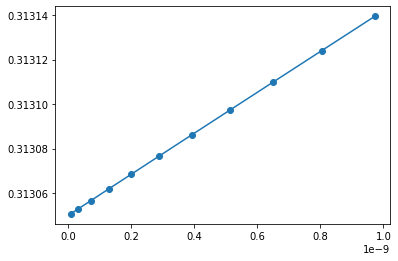

In [18]:
#Monitor detuning study, x direction
x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

dqx = np.zeros(N_particles)
jx = np.zeros(N_particles)

for ii in range(N_particles):
    dqx[ii] = qx_monitor[ii]
    jx[ii] = (x0[ii]*x0[ii])/(2*betx_at_ip3)
plt.plot(jx,dqx,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[2]],[dqx[0],dqx[2]])
print('m = ',slope,'q = ',intercept)

#print(tracker_monitor.record_last_track.x[0])
#len(tracker_monitor.record_last_track.x[0])
len(my_result['x'][:,ii])



m =  -1323780.6855884157 q =  0.3130498830485303


array([8.04233218e-12, 3.21693287e-11, 7.23809897e-11, 1.28677315e-10,
       2.01058305e-10, 2.89523959e-10, 3.94074277e-10, 5.14709260e-10,
       6.51428907e-10, 8.04233218e-10, 9.73122194e-10])

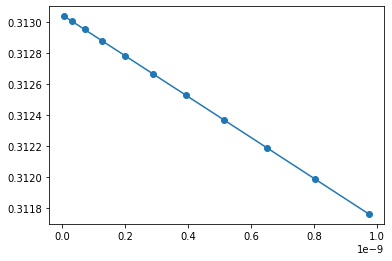

In [4]:
#Normal detuning study, x direction
dqx = np.zeros(N_particles)
jx = np.zeros(N_particles)

for ii in range(N_particles):
    dqx[ii] = qx_normal[ii]
    jx[ii] = (x0[ii]*x0[ii])/(2*betx_at_ip3)
plt.plot(jx,dqx,'-o');


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[2]],[dqx[0],dqx[2]])
print('m = ',slope,'q = ',intercept)

jx

m =  98396.08691759058 q =  0.31794989681652464


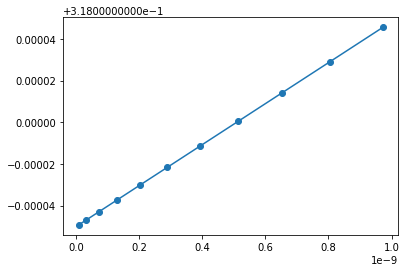

In [21]:
#Monitor detuning study, y direction

dqy = np.zeros(N_particles)
jy = np.zeros(N_particles)

for ii in range(N_particles):
    dqy[ii] = qy_monitor[ii]
    jy[ii] = (y0[ii]*y0[ii])/(2*bety_at_ip3)
plt.plot(jy,dqy,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])


slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[2]],[dqy[0],dqy[2]])
print('m = ',slope,'q = ',intercept)

m =  -1692657.7504595378 q =  0.3179498957249222


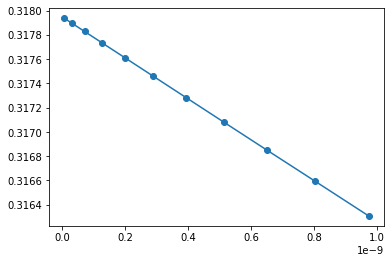

In [30]:
#Normal detuning study, y direction

dqy = np.zeros(N_particles)
jy = np.zeros(N_particles)

for ii in range(N_particles):
    dqy[ii] = qy_normal[ii]
    jy[ii] = (y0[ii]*y0[ii])/(2*bety_at_ip3)
plt.plot(jy,dqy,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])


slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[2]],[dqy[0],dqy[2]])
print('m = ',slope,'q = ',intercept)

In [28]:
qx_oct = [0.3130392367767762, 0.3130072668477651, 0.31295406648644775, 0.3128796612559198, 0.31278408167925603, 0.31266730805307313, 0.3125293308986112, 0.31237011602780185, 0.31218961238811094, 0.3119877663612319, 0.3117645252777741]
qx_no_oct = [0.31305066000753434, 0.3130529022749124, 0.31305663178354837, 0.3130618428745969, 0.3130685303763514, 0.3130766895984234, 0.3130863204690079, 0.31309740543336223, 0.31310996044315864, 0.3131239669885427, 0.31313943088427765]
qy_oct = [0.31793628278655894, 0.31789544259934155, 0.31782737942221667, 0.3177320814777581, 0.31760956634590476, 0.31745986045967894, 0.3172830122856016, 0.31707915400236925, 0.3168487597641903, 0.3165924554773461, 0.3163082566310991]
qy_no_oct = [0.3179506881505412, 0.3179530622785385, 0.3179570188226742, 0.3179625562382878, 0.31796968217004856, 0.3179783816723068, 0.31798866902724254, 0.31800053237955056, 0.3180139789749532, 0.318029008611634, 0.31804562082779614]

In [29]:
#plt.plot(jy,qx_no_oct)
sext_frac_x = np.zeros(N_particles)
sext_frac_y = np.zeros(N_particles)
for ii in range(N_particles):
    sext_frac_x[ii]=(qx_oct[ii]-qx_no_oct[ii])
    sext_frac_y[ii]=qy_oct[ii]/qy_no_oct[ii]
    print(sext_frac_x[ii])

-1.142323075814522e-05
-4.563542714730584e-05
-0.00010256529710062079
-0.0001821816186770575
-0.0002844486970953741
-0.0004093815453502514
-0.0005569895703967376
-0.0007272894055603829
-0.0009203480550477039
-0.001136200627310846
-0.0013749056065035514


In [149]:
qx_oct[0]

0.3130392367767762

In [150]:
qx_no_oct[0]

0.31305066000753434

m =  -1323780.9688996377 q =  0.31304988306306725


1000

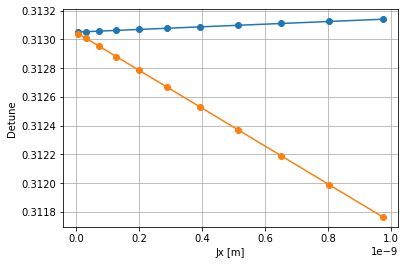

In [164]:
#Monitor detuning study, x direction
x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

jx = np.zeros(N_particles)


for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)



plt.plot(jx,qx_no_oct,'-o');
plt.plot(jx,qx_oct,'-o')
plt.grid()
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])
plt.ylabel('Detune')
plt.xlabel('Jx [m]')


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[2]],[qx_oct[0],qx_oct[2]])
print('m = ',slope,'q = ',intercept)

#print(tracker_monitor.record_last_track.x[0])
#len(tracker_monitor.record_last_track.x[0])
len(my_result['x'][:,ii])

In [116]:
np.array([mysigma*1 for mysigma in np.linspace(0.2,2.2,N_particles+1)]) 

array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2])

In [31]:
jx[4]

2.010583046058194e-10

- ```normal_emitt_x = 3e-6 #m*rad``` -> m
- ```sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))``` -> sqrt(m*m/no_dimension)-> m 
- ```jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)``` -> m*m/m -> m
- ```sum_nl_x+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['betx'][ii]```-> $m^{-3}$(?)*$m^{2}$-> $m^{-1}$
Total dqx (no dimension) = ang_coeff ($m^{-1}$) * jx ( m ) -> no dimension = no dimension !

In [53]:
tracker1 = xt.Tracker(_context=ctx_cpu, line=line)


generating ./f55de7ab1f1e416db258245b162bedf7.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building 'f55de7ab1f1e416db258245b162bedf7' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c f55de7ab1f1e416db258245b162bedf7.c -o ./f55de7ab1f1e416db258245b162bedf7.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

In [148]:
tw = tracker1.twiss(particle_0)
#print(tw['betx'][0])
#Scorrere sugli ottupoli
sum_nl_x = 0.0
count_nl_x = 0
sum_nl_y = 0.0
count_nl_y = 0
sum_nl_xy = 0.0
count_nl_xy = 0
sum_sl = 0.0
count_sl = 0
ii = 0
a = 0
for elem in line.element_dict :
    
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
        if(line.element_dict[elem].order==3):
                #print('elem is',elem,'and tw[name][elem]=',tw['name'][ii])
                if(a==0):
                    print(dir(line.element_dict[elem]))
                    print(line.element_dict[elem].track_kernel_description)
                    a=2
                #i print sono giusti, li commento perché sono lunghi
                #print('elem is',elem,'and tw[name][elem]=',tw['name'][ii],'with beta=',tw['betx'][ii])
                sum_nl_x+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['betx'][ii]
                count_nl_x+=1
                sum_nl_y+=line.element_dict[elem].knl[3]*tw['bety'][ii]*tw['bety'][ii]
                sum_nl_xy+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['bety'][ii]
                
                #count_nl_y+=1
                #print(elem)
                #print(line.element_dict[elem].knl)
    ii+=1

#print(sum_nl_x,sum_nl_y)
#print(count_nl_x,count_nl_y)
K_OCT_x = sum_nl_x
K_OCT_y = sum_nl_y
K_OCT_xy = sum_nl_xy

#print(K_OCT_x,K_OCT_y)
m_x = (K_OCT_x)/(16*np.pi)
m_y = (K_OCT_y)/(16*np.pi)
m_xy = (-K_OCT_xy)/(8*np.pi)

print(m_x,m_y,m_xy)

['XoStruct', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_buffer', '_fields', '_knl_setitem', '_ksl_setitem', '_move_to', '_offset', '_reinit_from_xobject', '_rename', '_store_in_to_dict', '_track_kernel_name', '_xobject', '_xofields', 'bal', 'compile_custom_kernels', 'compile_track_kernel', 'copy', 'from_dict', 'get_backtrack_element', 'hxl', 'hyl', 'iscollective', 'knl', 'ksl', 'length', 'order', 'radiation_flag', 'to_dict', 'track', 'track_kernel_description', 'track_kernel_source', 'xoinitialize']
{'Multipole_track_particles': <xobjects.context.Kernel object at 0x7f0142052490>}
-227341.61128685813 -225003.01024783653 140786.19331294773


In [153]:
-1323780.9688996377/-227341.61128685813

5.822871411029544

In [ ]:
-227341.61128685813 #at -350
-292296.3570789608  #at -450

In [48]:
450/350

1.2857142857142858

1.2857142844393024

m =  -330897.81597411167 q =  0.3130498815373966


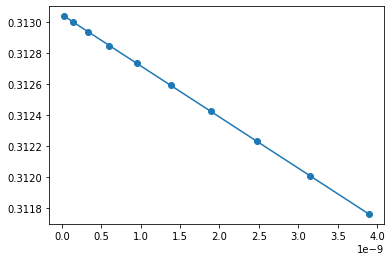

In [6]:
dqx = np.zeros(N_particles)
jx = np.zeros(N_particles)
for ii in range(N_particles):
    dqx[ii] = qx[ii]
    jx[ii] = (2*tracker_x.record_last_track.x[ii][0]*tracker_x.record_last_track.x[ii][0])/(betx_at_ip3)
plt.plot(jx,dqx,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[2]],[dqx[0],dqx[2]])
print('m = ',slope,'q = ',intercept)

ValueError: Cannot calculate a linear regression if all x values are identical

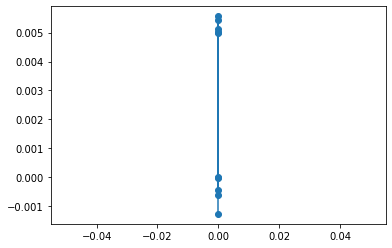

In [7]:
dqy = np.zeros(N_particles)
jy = np.zeros(N_particles)
for ii in range(N_particles):
    dqy[ii] = qy[ii]-qy[0]
    jy[ii] = (2*tracker_x.record_last_track.y[ii][0]*tracker_x.record_last_track.y[ii][0])/(bety_at_ip3)
plt.plot(jy,dqy,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])


slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[2]],[dqy[0],dqy[2]])
print('m = ',slope,'q = ',intercept)

In [ ]:
dqx_1 = np.zeros(N_particles)
jx = np.zeros(N_particles)
dqx_2 = np.zeros(N_particles)
jy = np.zeros(N_particles)
for ii in range(N_particles):
    dqx_1[ii] = qx[ii]-qx[0]
    dqx_2[ii] = qx[ii]-qx[0]
    jx[ii] = (2*tracker_x.record_last_track.x[ii][0]*tracker_x.record_last_track.x[ii][0])/(betx_at_ip3)
    jy[ii] = (2*tracker_x.record_last_track.y[ii][0]*tracker_x.record_last_track.y[ii][0])/(bety_at_ip3) 
plt.plot(jy,dqx_2,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])

slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[2]],[dqx[0],dqx[2]])
print('m = ',slope,'q = ',intercept)

In [ ]:
dqx = np.zeros(N_particles)
jx = np.zeros(N_particles)
for ii in range(N_particles):
    dqx[ii] = qx[ii]-qx[0]
    jx[ii] = (2*x0[ii]*x0[ii])/(betx_at_ip3)
plt.plot(jx,dqx,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[2]],[dqx[0],dqx[2]])
print('m = ',slope,'q = ',intercept)


In [ ]:
dqy = np.zeros(N_particles)
jy = np.zeros(N_particles)
for ii in range(N_particles):
    dqy[ii] = qy[ii]-qy[0]
    jy[ii] = (2*y0[ii]*y0[ii])/(bety_at_ip3)
plt.plot(jy,dqy,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])


slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[2]],[dqy[0],dqy[2]])
print('m = ',slope,'q = ',intercept)


In [ ]:
dqx_1 = np.zeros(N_particles)
jx = np.zeros(N_particles)
dqx_2 = np.zeros(N_particles)
jy = np.zeros(N_particles)
for ii in range(N_particles):
    dqx_1[ii] = qx[ii]-qx[0]
    dqx_2[ii] = qx[ii]-qx[0]
    jx[ii] = (2*x0[ii]*x0[ii])/(betx_at_ip3)
    jy[ii] = (2*y0[ii]*y0[ii])/(bety_at_ip3) 
plt.plot(jy,dqx_2,'-o');
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])

slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[2]],[dqx[0],dqx[2]])
print('m = ',slope,'q = ',intercept)

In [7]:
print(jy)
print(qy)



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.31794199172287396, 0.31793083446686354, 0.31791481539772803, 0.31789392871520683, 0.31786816941110385, 0.3178375375236618, 0.3178020173845922, 0.31776161981082673, 0.31771634036355473, 0.31766618470268393]


In [8]:
particles_x.x[0]

ERROR! Session/line number was not unique in database. History logging moved to new session 101


7.080036770955291e-05

In [9]:
print(sigma_x,sigma_y)


[0.00022103] [0.00029634]


Particle 1 has tune =  0.3133133133133133
Particle 2 has tune =  0.3133133133133133
Particle 3 has tune =  0.3133133133133133
Particle 4 has tune =  0.3133133133133133
Particle 5 has tune =  0.3133133133133133
Particle 6 has tune =  0.3133133133133133
Particle 7 has tune =  0.3133133133133133
Particle 8 has tune =  0.3133133133133133
Particle 9 has tune =  0.3133133133133133
Particle 10 has tune =  0.3133133133133133


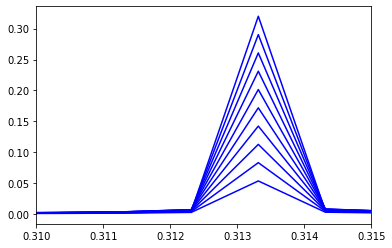

In [10]:
#print(np.max(qx_fft[2]))
xs = []
tunes_fft = []
for ii in range(N_particles):
    xs.append(np.linspace(0,1,N))
    plt.plot(xs[ii], qx_fft[ii], 'b')
    plt.xlim(0.310,0.315)
    maxqx = np.max(qx_fft[ii])
    for jj in range(N):
        if((np.isclose(qx_fft[ii][jj],maxqx))and(xs[ii][jj]<0.5)):
            tunes_fft.append(xs[ii][jj])
            print('Particle',ii+1,'has tune = ',xs[ii][jj])
            

Text(0, 0.5, 'Tunes')

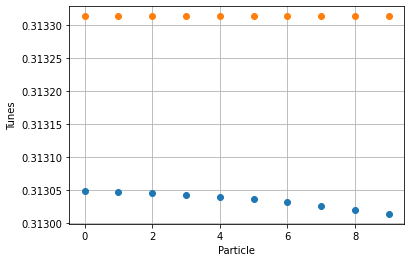

In [11]:
plt.plot(qx,'o');
plt.plot(tunes_fft,'o')
plt.grid()
plt.xlabel('Particle')
plt.ylabel('Tunes')